# Geospatial data visualization with Web Map Service (WMS) and NASA Global Imagery Browse Services (GIBS)

When mapping geospatial data (e.g. PM2.5 station data, aircraft flight tracks, model output), it is often informative and aesthetically pleasing to visually overlay other datasets as well, such as true-color Earth imagery, surface elevation, or other variables. 

Example. The figure below shows the locations of large (>400 ac) wildfires (red) and prescribed fires (green) in South Florida in 2018. True-color imagery from Landsat WELD provides information on land use and land cover. Fire perimeters are from MTBS.

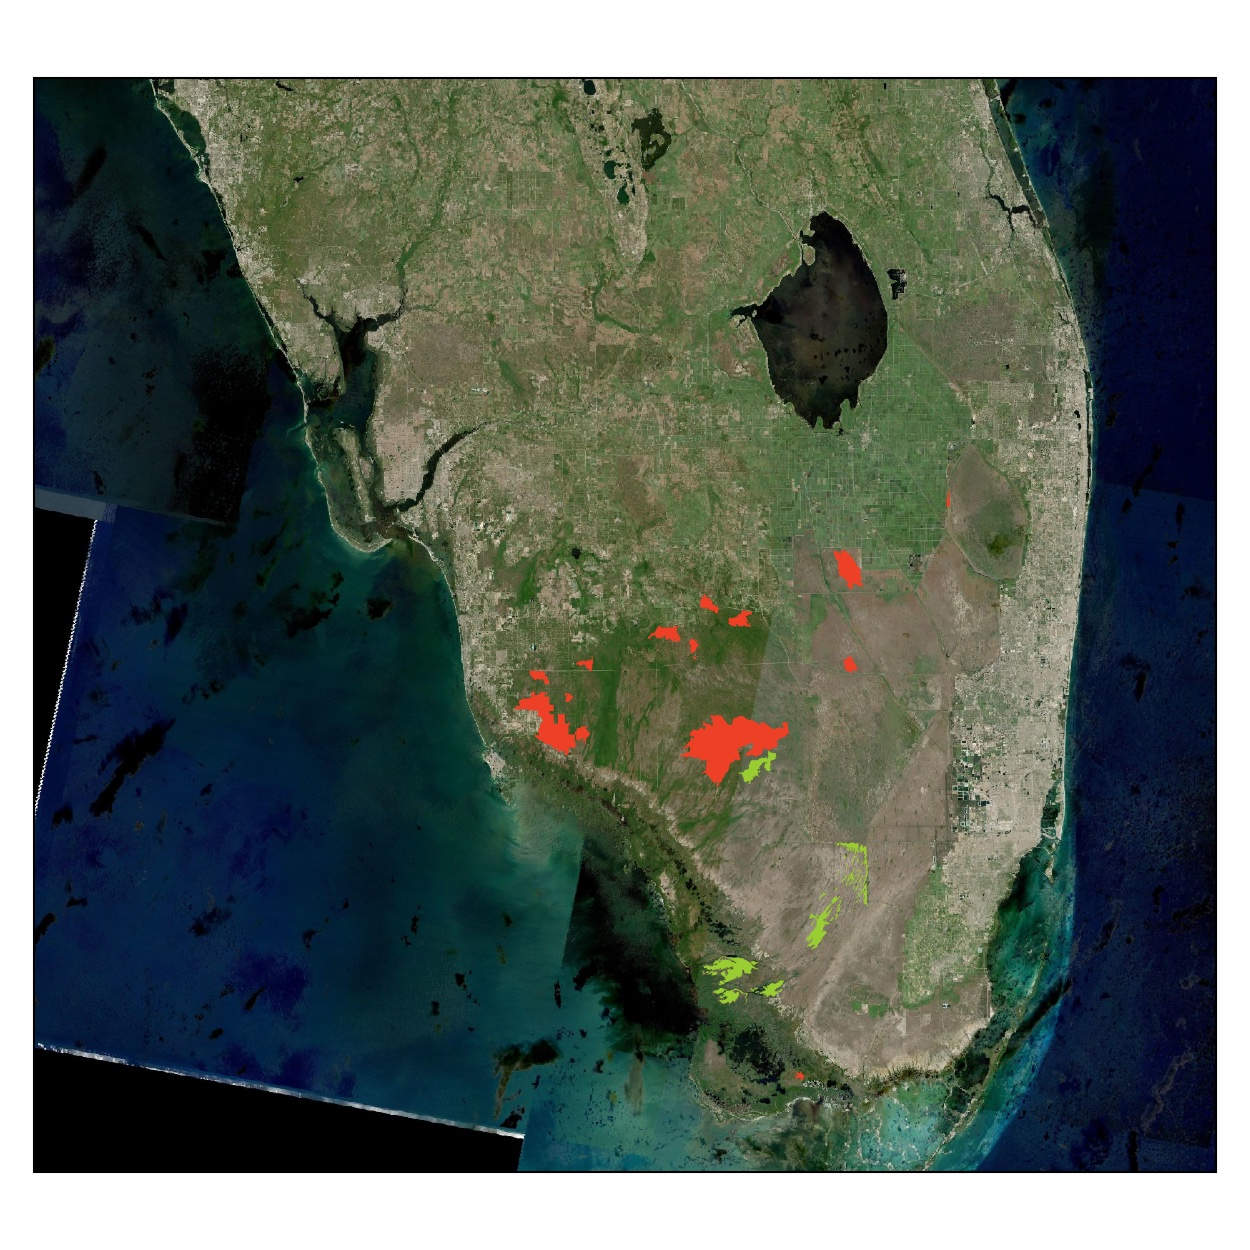

### WMS, WMTS and WFS
WMS, Web Map Tile Service (WMTS), and the Web Feature Service (WFS) are *protocols* for sharing geospatial data over the internet as images, without requiring the user to download the underlying data. (Quantitative analysis likely requires downloading the data.) Google Maps uses a protocol like WMS to deliver satellite, terrain, and political maps. 

Examples from Google Maps

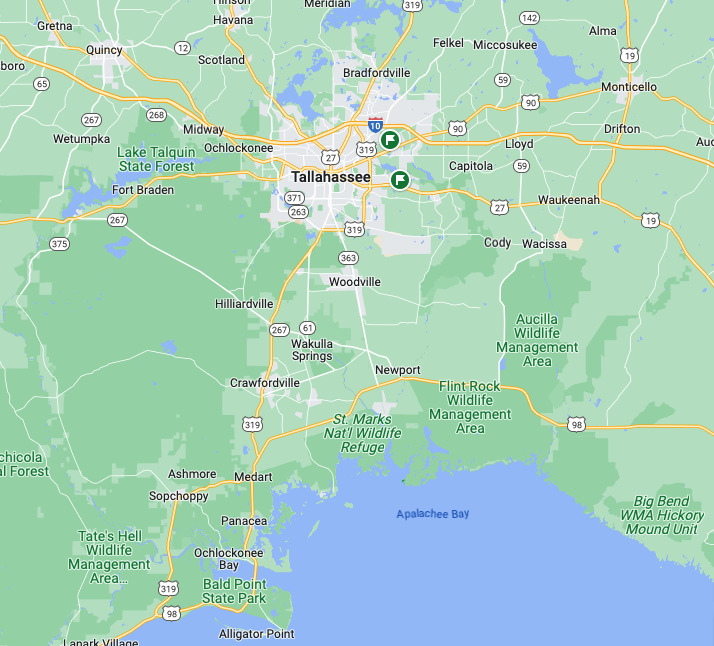
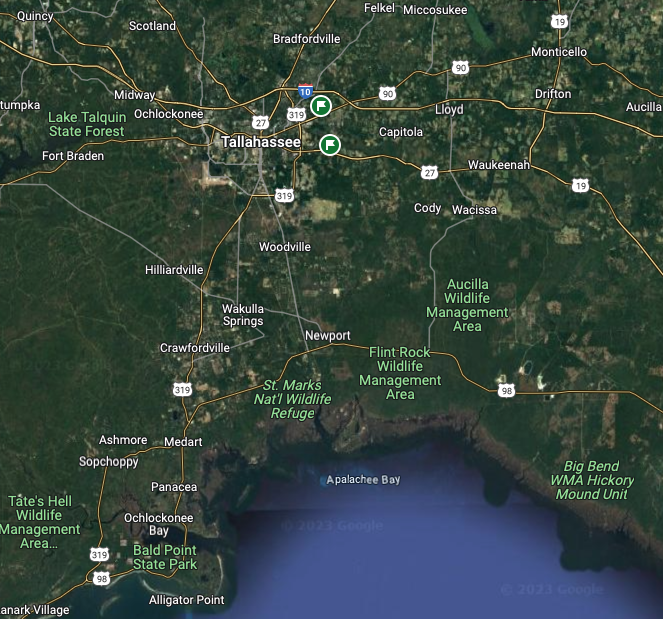

### OWSlib
[OWSlib](https://owslib.readthedocs.io) is a Python package for accessing WMTS, WMS, and other online geospatial data.

### GIBS
The [NASA GIBS](https://www.earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs) server provides a lot of Earth imagery and geospatial data through WMTS. See 
[NASA Worldview](https://worldview.earthdata.nasa.gov) to check out the available imagery. [GIBS Product catalog](https://nasa-gibs.github.io/gibs-api-docs/available-visualizations/#visualization-product-catalog)

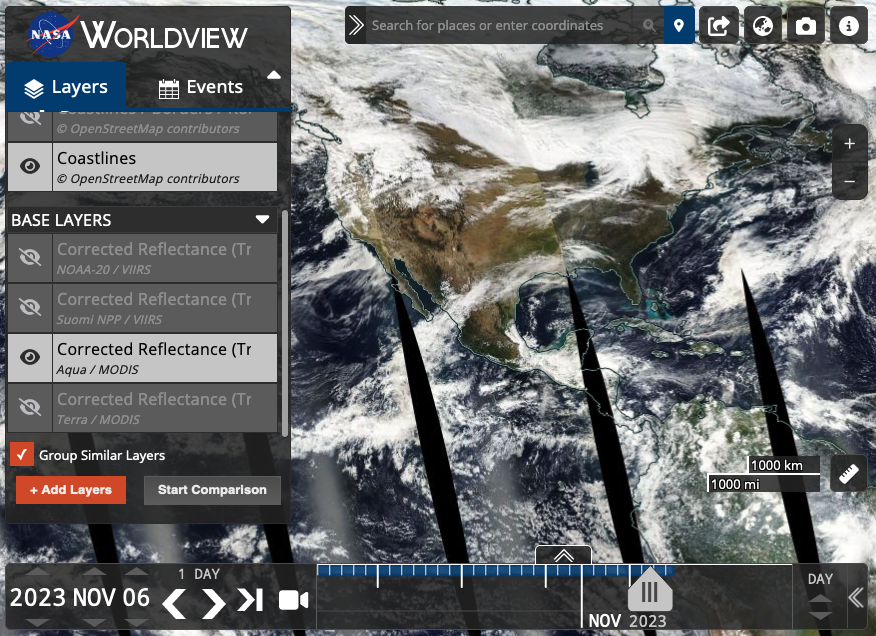


In [1]:
# Import packages
import matplotlib.pyplot as plt
from owslib.wmts import WebMapTileService
import cartopy.crs as ccrs

# NASA GIBS currently seems to return a faulty projection code (2022-11-19)
# These lines enable OWS to understand the faulty code
# This may become unneccessary in the future.
import cartopy.io.ogc_clients as ogcc
ogcc._URN_TO_CRS['urn:ogc:def:crs:EPSG:6.18:3:3857'] = ccrs.GOOGLE_MERCATOR
ogcc.METERS_PER_UNIT['urn:ogc:def:crs:EPSG:6.18:3:3857'] = 1

In [2]:
# Address for GIBS data
# epsg3857 (Web Mercator) and epsg4326 (Cylindrical Equirectangular, i.e. PlateCarree) are both fine for most purposes
# epsg3413 for Arctic 
# epsg3031 for Antarctic
URL = 'https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi'

#Ignore RuntimeWarning
wmts = WebMapTileService(URL)


/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/owslib/wmts.py:645: RuntimeWarning: TileMatrixLimits with tileMatrix "1" already exists
  warnings.warn(msg, RuntimeWarning)
/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/owslib/wmts.py:645: RuntimeWarning: TileMatrixLimits with tileMatrix "2" already exists
  warnings.warn(msg, RuntimeWarning)
/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/owslib/wmts.py:645: RuntimeWarning: TileMatrixLimits with tileMatrix "3" already exists
  warnings.warn(msg, RuntimeWarning)
/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/owslib/wmts.py:645: RuntimeWarning: TileMatrixLimits with tileMatrix "4" already exists
  warnings.warn(msg, RuntimeWarning)
/Users/cdholmes/anaconda3/envs/general/lib/python3.10/site-packages/owslib/wmts.py:645: RuntimeWarning: TileMatrixLimits with tileMatrix "5" already exists
  warnings.warn(msg, RuntimeWarning)
/Users/cdholmes/anaconda3/envs/gene

## Getting GIBS imagery products

* Find the product that interests you in the 
[GIBS product catalog](https://nasa-gibs.github.io/gibs-api-docs/available-visualizations/#visualization-product-catalog). Worldview can give you a preview of the images. 
* True color imagery is in the "Corrected Reflectance" and "Geostationary" categories.
* Locate the Name/Identifier for the product. e.g. "BlueMarble_NextGeneration"
* Products with temporal resolution have a period and temporal range specified in the catalog. Other products are static images (e.g. Blue Marble.) 

#### Some useful products
* BlueMarble_NextGeneration 
* VIIRS_Black_Marble 
* MODIS_Aqua_CorrectedReflectance_TrueColor - daily, 250 m resolution, also available from Terra instead of Aqua
* VIIRS_SNPP_CorrectedReflectance_TrueColor - daily, 250 m resolution, also available from NOAA20 instead of SNPP
* Landsat_WELD_CorrectedReflectance_TrueColor_Global_Annual - 30 m resolution, also available monthly
* GOES-East_ABI_GeoColor - 10 minute, 1 km, aslo available from GOES-West and HIMAWARI
* GPW_Population_Density_2020 - also 2000, 2005, 2010, 2015
* Reference_Features_15m - coastlines, borders, roads
* Reference_Labels_15m - place names
* ASTER_GDEM_Color_Shaded_Relief - terrain altitude, also Index instead of Shaded_Relief
* MODIS_Combined_Thermal_Anomalies_All, VIIRS_NOAA20_Thermal_Anomalies_375m_All, VIIRS_SNPP_Thermal_Anomalies_375m_All 


### Examples: Blue Marble and MODIS daily

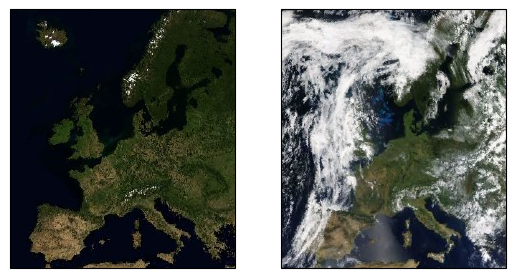

In [3]:
# Map projection
mapproj = ccrs.EuroPP()

# Create the plot axes with desired projection
fig, axs  = plt.subplots( nrows=1, ncols=2, 
            subplot_kw=dict(projection=mapproj) )

# Add Blue Marble
axs[0].add_wmts( wmts, 'BlueMarble_NextGeneration' ) 

# Add MODIS for specific day
axs[1].add_wmts( wmts, 'MODIS_Aqua_CorrectedReflectance_TrueColor', 
                wmts_kwargs={'time': '2015-07-01'} ) 

### Examples: Population density and fire detections

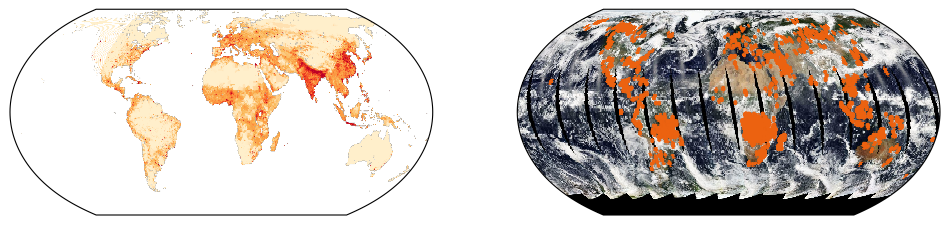

In [28]:
# Map projection
mapproj = ccrs.EqualEarth()

# Create the plot axes with desired projection
fig, axs  = plt.subplots( nrows=1, ncols=2, 
            subplot_kw=dict(projection=mapproj),
             figsize=(12,7) )

# Population density
axs[0].add_wmts( wmts, 'GPW_Population_Density_2020' ) 

# MODIS and MODIS fire detections
# Note that this uses WMS because fire detections is a vector object
axs[1].add_wms( 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi',
                ['MODIS_Aqua_CorrectedReflectance_TrueColor',
                 'MODIS_Combined_Thermal_Anomalies_All', ], 
                wms_kwargs={'time': '2015-07-01',
                            'transparent':True} ) 